In [ ]:
from selenium import webdriver
from bs4 import BeautifulSoup
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime


In [ ]:
driver = webdriver.Firefox(executable_path=r'geckodriver.exe')


In [ ]:
lluvia_diaria = pd.DataFrame(
    columns=['fecha_registro', 'probalidad_lluvia', 'precipitacion', 'fecha_pronostico'])
fecha = date.today()
for dia in range(1, 91):
    driver.get(
        f"https://www.accuweather.com/es/cl/santiago/60449/daily-weather-forecast/60449?day={dia}")
    content = driver.page_source
    soup = BeautifulSoup(content)
    tabla = soup.find_all('p', {'class': 'panel-item'})
    for i in tabla:
        value = i.get_text(separator=",").split(",")
        if value[0] == "Probabilidad de precipitación":
            probabilidad = float(value[1].replace("%", ""))/100
        if value[0] == "Precipitaciones":
            precipitaciones = float(value[1].replace("mm", ""))
            break
    fecha_pronostico = fecha+timedelta(days=(dia-1))
    lluvia_diaria.loc[len(lluvia_diaria)] = [
        fecha, probabilidad, precipitaciones, fecha_pronostico]
lluvia_diaria.to_csv(
    f'data\lluvia_diaria_{fecha}_{datetime.now().hour}.csv', sep=";", decimal=",", index=False)


In [45]:
import os
archivos = os.listdir('data')
lluvia_esperada_total = pd.DataFrame()
for arch in archivos:
    df = pd.read_csv(f"data/{arch}", sep=";", decimal=",")
    df['lluvia_esperada'] = df['probalidad_lluvia']*df['precipitacion']
    df['acumulado'] = df['lluvia_esperada'].cumsum()
    lluvia_esperada_total = pd.concat([lluvia_esperada_total, df])
lluvia_esperada_total.reset_index(inplace=True, drop=True)
lluvia_esperada_total['fecha_pronostico'] = pd.to_datetime(lluvia_esperada_total['fecha_pronostico'])



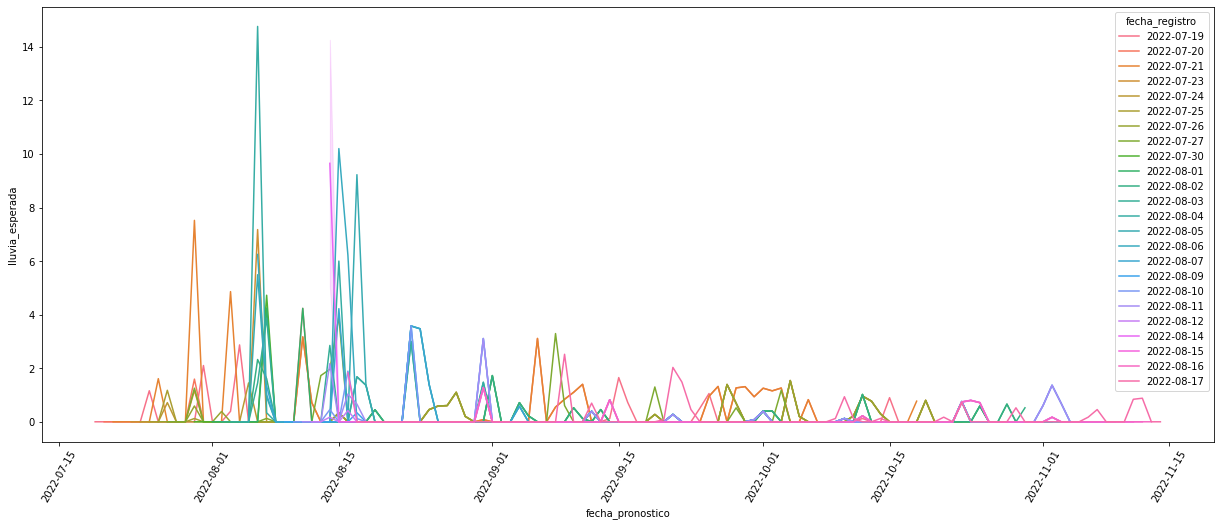

In [46]:
plt.figure(figsize=(21, 8))
ax = sns.lineplot(data=lluvia_esperada_total[lluvia_esperada_total['fecha_registro']
                  >= "2022-07-19"], x='fecha_pronostico', y='lluvia_esperada', hue='fecha_registro')
plt.xticks(rotation=60)
plt.show()


In [47]:
lluvia_real = pd.read_csv('lluvia_real_web.csv',sep=";", decimal=",")
lluvia_real['fecha'] = pd.to_datetime(lluvia_real['fecha'],infer_datetime_format=True)
lluvia_real['lluvia_promedio'] = lluvia_real.mean(axis=1)
lluvia_real['acumulado_real'] = lluvia_real['lluvia_promedio'].cumsum()
lluvia_real

<ipython-input-47-e9b0c6dba490>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  lluvia_real['lluvia_promedio'] = lluvia_real.mean(axis=1)


,fecha,lluvia_330114,lluvia_330020,lluvia_330019,lluvia_330021,lluvia_promedio,acumulado_real
0,2022-05-23,0.0,0.0,0.0,0.0,0.000,0.000
1,2022-05-24,0.0,0.0,0.0,0.0,0.000,0.000
2,2022-05-25,0.0,0.0,0.0,0.0,0.000,0.000
3,2022-05-26,0.1,0.0,0.0,0.0,0.025,0.025
4,2022-05-27,0.0,0.0,0.0,0.0,0.000,0.025
...,...,...,...,...,...,...,...
81,2022-08-12,0.0,0.0,0.0,0.0,0.000,105.775
82,2022-08-13,0.1,0.0,0.0,0.0,0.025,105.800
83,2022-08-14,6.9,8.2,18.6,6.9,10.150,115.950
84,2022-08-15,0.0,0.6,0.0,0.0,0.150,116.100


In [48]:
lluvia_esperada_total.groupby(['fecha_registro'])['lluvia_esperada'].sum()


fecha_registro
2022-05-23     87.342
2022-05-24     79.965
2022-05-25     88.967
2022-05-26    140.962
2022-05-27    140.155
               ...   
2022-08-12      5.341
2022-08-14     28.797
2022-08-15      4.749
2022-08-16      6.574
2022-08-17     12.331
Name: lluvia_esperada, Length: 66, dtype: float64

In [49]:
lluvia_esperada_total = lluvia_esperada_total.merge(
    lluvia_real, left_on='fecha_pronostico', right_on='fecha', how='left')
lluvia_esperada_total


,fecha_registro,probalidad_lluvia,precipitacion,fecha_pronostico,lluvia_esperada,acumulado,fecha,lluvia_330114,lluvia_330020,lluvia_330019,lluvia_330021,lluvia_promedio,acumulado_real
0,2022-05-23,0.15,0.0,2022-05-23,0.00,0.000,2022-05-23,0.0,0.0,0.0,0.0,0.000,0.000
1,2022-05-23,0.25,0.0,2022-05-24,0.00,0.000,2022-05-24,0.0,0.0,0.0,0.0,0.000,0.000
2,2022-05-23,0.04,0.0,2022-05-25,0.00,0.000,2022-05-25,0.0,0.0,0.0,0.0,0.000,0.000
3,2022-05-23,0.04,0.0,2022-05-26,0.00,0.000,2022-05-26,0.1,0.0,0.0,0.0,0.025,0.025
4,2022-05-23,0.08,0.0,2022-05-27,0.00,0.000,2022-05-27,0.0,0.0,0.0,0.0,0.000,0.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6385,2022-08-17,0.29,0.0,2022-11-10,0.00,10.611,NaT,NaN,NaN,NaN,NaN,NaN,NaN
6386,2022-08-17,0.40,2.1,2022-11-11,0.84,11.451,NaT,NaN,NaN,NaN,NaN,NaN,NaN
6387,2022-08-17,0.40,2.2,2022-11-12,0.88,12.331,NaT,NaN,NaN,NaN,NaN,NaN,NaN
6388,2022-08-17,0.00,0.0,2022-11-13,0.00,12.331,NaT,NaN,NaN,NaN,NaN,NaN,NaN


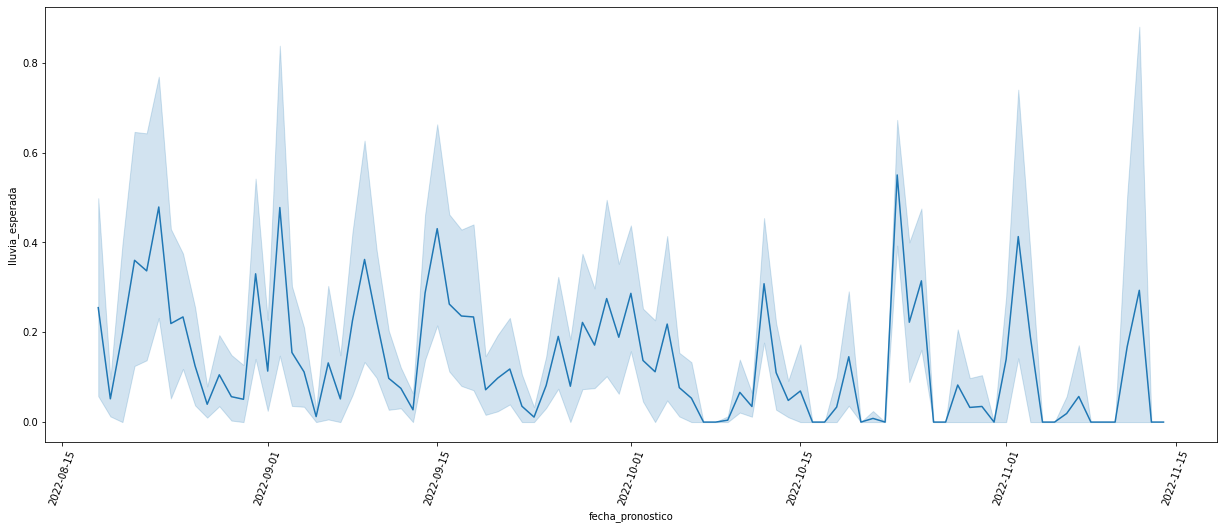

In [37]:
plt.figure(figsize=(21, 8))
ax = sns.lineplot(data=lluvia_esperada_total[lluvia_esperada_total['fecha_pronostico']
                  > str(date.today())], x="fecha_pronostico", y="lluvia_esperada")
plt.xticks(rotation=70)
plt.show()


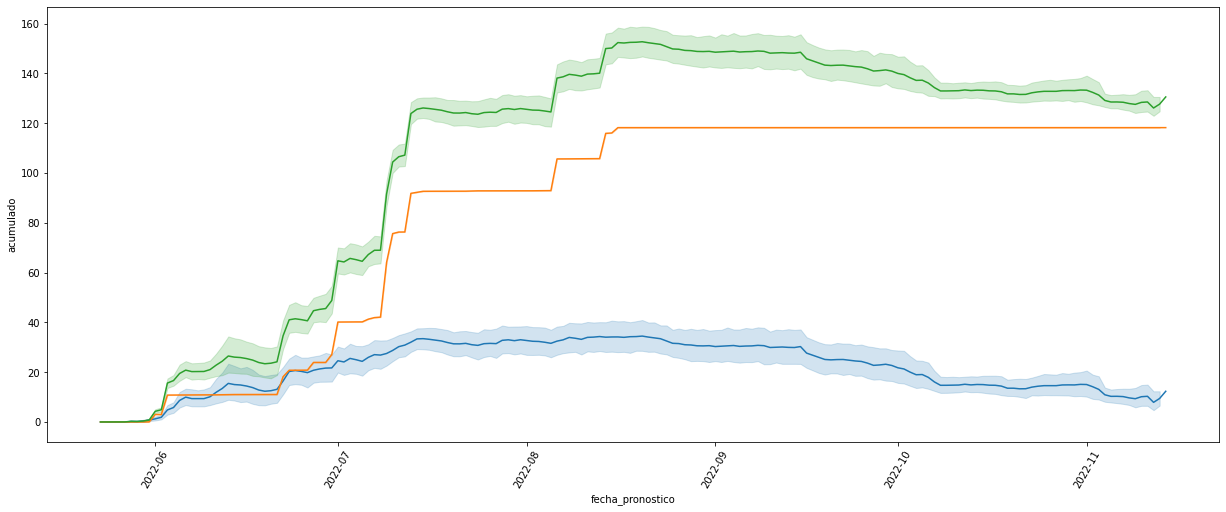

In [50]:
lluvia_esperada_total['acumulado_real'].fillna(
    max(lluvia_esperada_total['acumulado_real']), inplace=True)
lluvia_esperada_total['acumulado_True'] = lluvia_esperada_total['acumulado_real'] + \
    lluvia_esperada_total['acumulado']

plt.figure(figsize=(21, 8))
ax = sns.lineplot(data=lluvia_esperada_total,
                  x="fecha_pronostico", y="acumulado")
ax = sns.lineplot(data=lluvia_esperada_total,
                  x="fecha_pronostico", y="acumulado_real")
ax = sns.lineplot(data=lluvia_esperada_total,
                  x="fecha_pronostico", y="acumulado_True")
plt.xticks(rotation=60)
plt.show()


In [ ]:
lluvia_esperada_total.tail(50)
